<a href="https://colab.research.google.com/github/Philliec459/Open-Source-Petrophysics/blob/main/Gaussian_Clerke_Spreadsheet/Panel_Bvocc_ver6_GitHub_colab_GEV_CDF.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:

    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Gaussian_Clerke_Spreadsheet/Thomeer_spreadsheet_Clerke.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


# Gaussian Fit of HPMI data

## Load Python libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import panel as pn
#pn.extension('matplotlib')
#pn.extension()


pn.extension(comms='colab')

from scipy.optimize import minimize

from scipy.stats import norm



# Load Data

HPMI Data from Ed Clerke Thomeer type Spreadsheet that he gives out.



In [4]:

# Specify the file path and sheet number
file_path = 'Thomeer_spreadsheet_Clerke.xlsx'
sheet_number = 0  # Replace with the index of your desired sheet (e.g., 0 for the first sheet)

# Read the specific range from the sheet
data = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A:B", skiprows=7, nrows=106)

# Rename the columns to something meaningful
data.columns = ['Pc', 'BVocc']

# Display the data
print(data)

Pc     = np.array(data['Pc'])
BVocc  = np.array(data['BVocc'])

dbvocc = np.diff(BVocc)          # diff of BVocc for distribution, but loose one element in the array
dbvocc = np.insert(dbvocc,0,0)   # Our final dbvocc after adding a zero at the end.
print(len(dbvocc))



# Read Porosity for the current sample
porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols="B", skiprows=3, nrows=1).iloc[0, 0]

# Read Permeability for the current sample
permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols="B", skiprows=4, nrows=1).iloc[0, 0]

# Read Sample Number for the current sample
sample_no = pd.read_excel(file_path, sheet_name=sheet_number, usecols="B", skiprows=1, nrows=1).iloc[0, 0]

# Read Permeability for the current sample
closure_pick = pd.read_excel(file_path, sheet_name=sheet_number, usecols="D", skiprows=2, nrows=1).iloc[0, 0]

# Display the data
print('Porosity =', porosity,', Permeability =' , permeability , ', Sample_no =', sample_no, ', Closure Correction SCAL =' ,  closure_pick, 'pu')


Sw = 1 - BVocc/max(BVocc)

               Pc      BVocc
0        0.560000   0.002215
1        0.630000   0.057355
2        0.710000   0.143127
3        0.800000   0.243194
4        0.900000   0.329696
..            ...        ...
101  32434.800781  26.072508
102  36141.058594  26.101098
103  40270.828125  26.141088
104  44872.500000  26.178972
105  50000.000000  26.228513

[106 rows x 2 columns]
106
Porosity = 24.2 , Permeability = 168 , Sample_no = Sample 1 , Closure Correction SCAL = 1.6 pu


# Traditional Gaussian Parameter Code:

w [0.44196935 0.55803065] u [ 0.86354164 -0.19691882] sig [0.14160661 0.92531401]


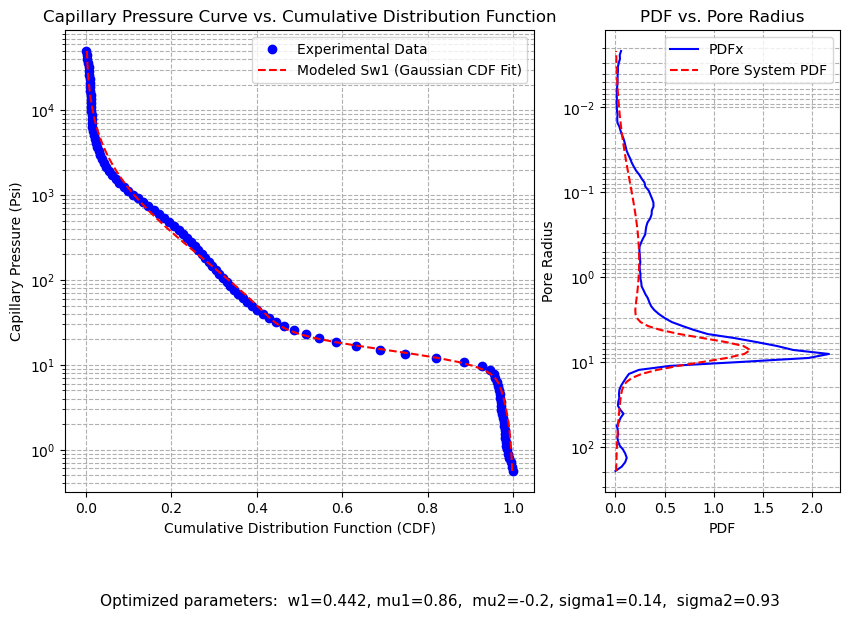

In [5]:

''' Definitions '''


def micp_to_gaussian(Pc, Sw, IFTheta, n):
    Rc = 2 * IFTheta * 0.147 / Pc
    Rc = Rc[Rc > 0]  # Remove non-positive Rc values

    if len(Rc) == 0:
        raise ValueError("All Rc values are invalid.")

    ''' Initial guess '''
    x0 = np.array([0.2, 0.8, -2, -0.5, 0.05, 0.6])

    ''' Lower and upper bounds '''
    lb = np.array([0.002, 0.002, np.log10(Rc[-1]), np.log10(Rc[-1]), 0.01, 0.01])
    ub = np.array([1, 1, np.log10(Rc[0]), np.log10(Rc[0]), 5, 5])

    ''' Constraints '''
    Aeq = np.array([1] * n + [0] * 2 * n)
    Beq = np.array([1])

    ''' Objective function '''
    def gaussian_cost_function(t):
        return gaussian_cost(np.log10(Rc), Sw, t, n)

    ''' Minimize the objective function with constraints '''
    cons = [{'type': 'eq', 'fun': lambda t: np.dot(Aeq, t) - Beq}]
    bounds = [(low, high) for low, high in zip(lb, ub)]

    res = minimize(gaussian_cost_function, x0, bounds=bounds, constraints=cons, method='SLSQP')

    if not res.success:
        print("Optimization failed:", res.message)
        return None

    x = res.x
    w = x[:n]
    u = x[n:2 * n]
    sig = x[2 * n:]

    ''' Sort u and adjust w and sigma accordingly '''
    sorted_indices = np.argsort(u)[::-1]
    u = u[sorted_indices]
    w = w[sorted_indices]
    sig = sig[sorted_indices]

    ''' Calculate Sw1 and PDF '''
    Sw1 = np.zeros_like(Sw)
    pdf = np.zeros_like(Sw)
    for i in range(len(Pc)):
        if Rc[i] > 0:
            Sw1[i] = np.sum(norm.cdf(np.log10(Rc[i]), u, sig) * w)
            pdf[i] = np.sum(norm.pdf(np.log10(Rc[i]), u, sig) * w)


    #   Is this necessary? 
    ''' Generate Rcx and Pcx 
    Rcx = np.logspace(-4, 4, 10000)
    Pcx = 2 * IFTheta / Rcx
    Swx = np.zeros_like(Rcx)
    Pdfx = np.zeros_like(Rcx)
    for i in range(len(Rcx)):
        if Rcx[i] > 0:
            Swx[i] = np.sum(norm.cdf(np.log10(Rcx[i]), u, sig) * w)
            Pdfx[i] = np.sum(norm.pdf(np.log10(Rcx[i]), u, sig) * w)

    Interpolate Pc2 for Sw2 
    Sw2 = np.linspace(0.998, 0.02, 100)
    M = np.where(Swx < 0.99)[0]
    if len(M) > 0:
        Pc2 = np.interp(Sw2, Swx[:M[-1]], Pcx[:M[-1]])
    else:
        Pc2 = None
    '''
 
    #return w, u, sig, x, Sw1, pdf, Rc, Sw2, Pc2, Rcx, Pdfx, Swx
    
    return w, u, sig, x, Sw1, pdf, Rc

def gaussian_cost(X, c, t, n):
    w = t[:n]
    mu = t[n:2 * n]
    sigma = t[2 * n:]

    cm = np.zeros_like(c)
    for i in range(len(X)):
        cm[i] = np.sum(norm.cdf(X[i], mu, sigma) * w)

    c = np.array(c)  # Ensure c is a numpy array
    
    # Element-wise comparison
    idx = np.where(c <= 1)[0]
    e   = np.linalg.norm(cm[idx] - c[idx])

    return e


def plot_micp_results2(Pc, Sw, Sw1):

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    # Plot Capillary Pressure vs. CDF
    ax1.plot(Sw, Pc, 'bo', label='Experimental Data')
    # Plot modeled Sw1 (Gaussian Fit) vs Pc
    ax1.plot(Sw1, Pc, 'r--', label='Modeled Sw1 (Gaussian CDF Fit)')
    ax1.set_yscale('log')
    ax1.set_xlabel('Cumulative Distribution Function (CDF)')
    ax1.set_ylabel('Capillary Pressure (Psi)')
    ax1.set_title('Capillary Pressure Curve vs. Cumulative Distribution Function')
    ax1.grid(True, which="both", ls="--")
    ax1.legend()

    # Add the text below the plot
    text_string = (
                   f'Optimized parameters:  w1={round(w[0], 3)}, '
                   f'mu1={round(u[0], 2)},  mu2={round(u[1], 2)}, '
                   f'sigma1={round(sig[0], 2)},  sigma2={round(sig[1], 2)}')

    # Adjust the position of the text as needed
    plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)


    
    
    # Plot PDF with reversed axes
    ax2.plot(dSw, Rc, 'b-', label='PDFx')
    ax2.plot(pdf, Rc, 'r--', label='Pore System PDF')
    ax2.set_xscale('linear')
    ax2.set_yscale('log')
    plt.gca().invert_yaxis()
    ax2.set_xlabel('PDF')
    ax2.set_ylabel('Pore Radius')
    ax2.set_title('PDF vs. Pore Radius')
    ax2.grid(True, which="both", ls="--")
    ax2.legend()




''' Data Entry '''

# Example of how to use the function:
#Pc = [0.5,0.56,0.63,0.71,0.8,0.9,1.01,1.11,1.24,1.38,1.54,1.72,1.91,2.13,2.38,2.65,2.95,3.29,3.66,4.08,4.55,5.07,5.65,6.29,7.01,7.81,8.71,9.7,10.81,12.04,13.42,14.95,16.66,18.57,20.69,23.05,25.69,28.62,31.89,35.54,39.6,44.12,49.16,54.78,61.04,68.01,75.79,84.45,94.1,104.85,116.83,130.18,145.05,161.63,180.1,200.68,223.61,249.16,277.63,309.35,344.7,384.09,427.98,476.88,531.38,592.1,659.75,735.14,819.15,912.75,1017.05,1133.26,1262.76,1407.05,1567.83,1746.99,1946.61,2169.05,2416.9,2693.07,3000.81,3343.7,3725.78,4151.52,4625.9,5154.5,5743.49,6399.79,7131.08,7945.94,8853.9,9865.62,10992.95,12249.09,13648.77,15208.39,16946.23,18882.64,21040.32,23444.56,26123.53,29108.61,32434.8,36141.06,40270.83,44872.5,50000]
#Sw = [1,1,0.998,0.995,0.991,0.987,0.985,0.984,0.983,0.982,0.981,0.98,0.98,0.979,0.977,0.974,0.973,0.972,0.971,0.97,0.968,0.967,0.965,0.963,0.959,0.954,0.946,0.928,0.886,0.821,0.749,0.689,0.634,0.587,0.547,0.515,0.489,0.466,0.447,0.431,0.416,0.403,0.391,0.379,0.368,0.358,0.349,0.34,0.331,0.323,0.314,0.306,0.298,0.29,0.281,0.273,0.265,0.257,0.248,0.239,0.229,0.219,0.208,0.198,0.186,0.174,0.161,0.149,0.136,0.123,0.112,0.1,0.09,0.081,0.072,0.064,0.057,0.051,0.045,0.04,0.036,0.032,0.029,0.026,0.023,0.021,0.019,0.018,0.017,0.016,0.016,0.015,0.015,0.014,0.014,0.013,0.013,0.012,0.012,0.011,0.01,0.009,0.009,0.008,0.006,0.005,0.003]

# Example usage (replace Pc, Sw, IFTheta with real values):
Pc = np.array(Pc)  # Replace with actual Pc values
Sw = np.array(Sw)  # Replace with actual Sw values
dSw = np.diff(-1*Sw)
dSw = 30*np.insert(dSw,0,0)



# IFTheta needs to be positive
IFTheta = abs(480 * np.cos(np.radians(140)))  # Use the absolute value of IFTheta
n = 2  # Number of Gaussian components


# Run the model and plot results
result = micp_to_gaussian(Pc, Sw, IFTheta, n)


#w, u, sig, x, Sw1, pdf, Rc, Sw2, Pc2, Rcx, Pdfx, Swx = result
w, u, sig, x, Sw1, pdf, Rc = result

plot_micp_results2(Pc, Sw, Sw1)


print('w',w, 'u', u, 'sig',sig) #, 'x', x, 'Sw1', Sw1, 'pdf',pdf, 'Rc', Rc, 'Sw2', Sw2, 'Pc2',Pc2, 'Rcx',Rcx, 'Pdfx', Pdfx, 'Swx', Swx )

# Generalized Extreme Value(GEV) CDF - PDF:

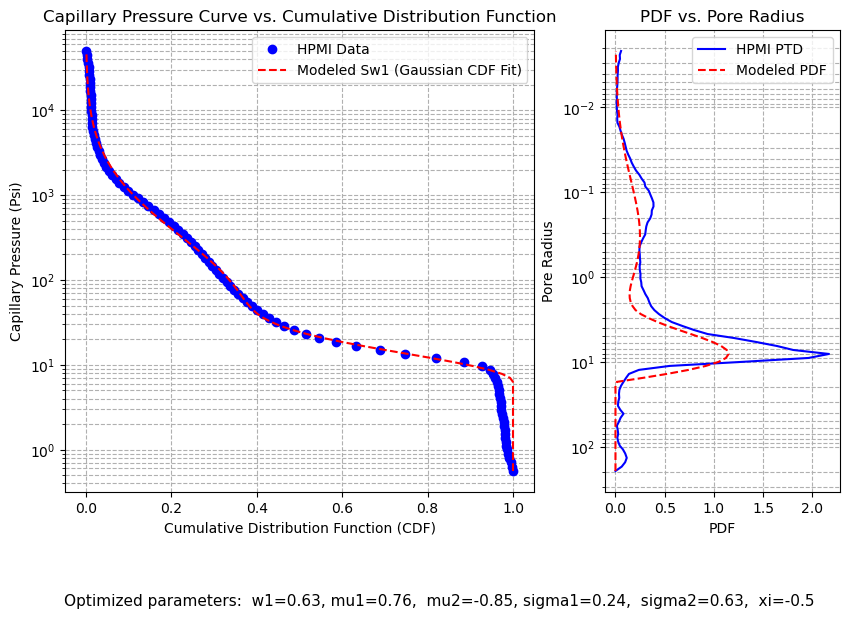

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import genextreme
import matplotlib.pyplot as plt

def micp_to_gev(Pc, Sw, IFTheta, n):
    
    Rc = 2 * IFTheta * 0.147 / Pc

    
    ''' Initial guess '''
    x0 = np.array([0.2, 0.8, -2, -0.5, 0.05, 0.6])

    ''' Lower and upper bounds '''
    lb = np.array([0.002, 0.002, np.log10(Rc[-1]), np.log10(Rc[-1]), 0.01, 0.01])
    ub = np.array([1, 1, np.log10(Rc[0]), np.log10(Rc[0]), 5, 5])

    ''' Constraints '''
    Aeq = np.array([1] * n + [0] * 2 * n)
    Beq = np.array([1])

    ''' Objective function (using GEV CDF instead of normal CDF) '''
    def gev_cost_function(t):
        return gev_cost(np.log10(Rc), Sw, t, n)

    ''' Minimize the objective function with constraints '''
    cons = [{'type': 'eq', 'fun': lambda t: np.dot(Aeq, t) - Beq}]
    bounds = [(low, high) for low, high in zip(lb, ub)]

    res = minimize(gev_cost_function, x0, bounds=bounds, constraints=cons, method='SLSQP')

    x = res.x
    w = x[:n]
    u = x[n:2 * n]
    sig = x[2 * n:]

    ''' Sort u and adjust w and sigma accordingly '''
    sorted_indices = np.argsort(u)[::-1]
    u = u[sorted_indices]
    w = w[sorted_indices]
    sig = sig[sorted_indices]

    ''' Calculate Sw1 and PDF using GEV distribution '''
    Sw1 = np.zeros_like(Sw)
    pdf = np.zeros_like(Sw)
    for i in range(len(Pc)):
        Sw1[i] = np.sum(genextreme.cdf(np.log10(Rc[i]), 0.5, u, sig) * w)  # xi=0 for Gumbel (special case of GEV)
        pdf[i] = np.sum(genextreme.pdf(np.log10(Rc[i]), 0.5, u, sig) * w)


    return w, u, sig, x, Sw1, pdf, Rc

def gev_cost(X, c, t, n):
    w = t[:n]
    mu = t[n:2 * n]
    sigma = t[2 * n:]

    cm = np.zeros_like(c)
    for i in range(len(X)):
        cm[i] = np.sum(genextreme.cdf(X[i], 0.5 , mu, sigma) * w)  # xi=0 for Gumbel (special case of GEV)

    c = np.array(c)  # Ensure c is a numpy array
    
    # Element-wise comparison
    idx = np.where(c <= 1)[0]
    e   = np.linalg.norm(cm[idx] - c[idx])

    return e



def plot_micp_results_gev(Pc, Sw, Sw1):

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    # Plot Capillary Pressure vs. CDF
    ax1.plot(Sw, Pc, 'bo', label='HPMI Data')
    # Plot modeled Sw1 (Gaussian Fit) vs Pc
    ax1.plot(Sw1, Pc, 'r--', label='Modeled Sw1 (Gaussian CDF Fit)')
    ax1.set_yscale('log')
    ax1.set_xlabel('Cumulative Distribution Function (CDF)')
    ax1.set_ylabel('Capillary Pressure (Psi)')
    ax1.set_title('Capillary Pressure Curve vs. Cumulative Distribution Function')
    ax1.grid(True, which="both", ls="--")
    ax1.legend()

    # Add the text below the plot
    text_string = (
                   f'Optimized parameters:  w1={round(w[0], 2)}, '
                   f'mu1={round(u[0], 2)},  mu2={round(u[1], 2)}, '
                   f'sigma1={round(sig[0], 2)},  sigma2={round(sig[1], 2)},  xi=-0.5')

    # Adjust the position of the text as needed
    plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)


    
    
    # Plot PDF with reversed axes
    ax2.plot(dSw, Rc, 'b-', label='HPMI PTD')
    ax2.plot(pdf, Rc, 'r--', label='Modeled PDF')
    ax2.set_xscale('linear')
    ax2.set_yscale('log')
    plt.gca().invert_yaxis()
    ax2.set_xlabel('PDF')
    ax2.set_ylabel('Pore Radius')
    ax2.set_title('PDF vs. Pore Radius')
    ax2.grid(True, which="both", ls="--")
    ax2.legend()


# Example data (replace Pc, Sw with real values):
#Pc = [0.5,0.56,0.63,0.71,0.8,0.9,1.01,1.11,1.24,1.38,1.54,1.72,1.91,2.13,2.38,2.65,2.95,3.29,3.66,4.08,4.55,5.07,5.65,6.29,7.01,7.81,8.71,9.7,10.81,12.04,13.42,14.95,16.66,18.57,20.69,23.05,25.69,28.62,31.89,35.54,39.6,44.12,49.16,54.78,61.04,68.01,75.79,84.45,94.1,104.85,116.83,130.18,145.05,161.63,180.1,200.68,223.61,249.16,277.63,309.35,344.7,384.09,427.98,476.88,531.38,592.1,659.75,735.14,819.15,912.75,1017.05,1133.26,1262.76,1407.05,1567.83,1746.99,1946.61,2169.05,2416.9,2693.07,3000.81,3343.7,3725.78,4151.52,4625.9,5154.5,5743.49,6399.79,7131.08,7945.94,8853.9,9865.62,10992.95,12249.09,13648.77,15208.39,16946.23,18882.64,21040.32,23444.56,26123.53,29108.61,32434.8,36141.06,40270.83,44872.5,50000]
#Sw = [1,1,0.998,0.995,0.991,0.987,0.985,0.984,0.983,0.982,0.981,0.98,0.98,0.979,0.977,0.974,0.973,0.972,0.971,0.97,0.968,0.967,0.965,0.963,0.959,0.954,0.946,0.928,0.886,0.821,0.749,0.689,0.634,0.587,0.547,0.515,0.489,0.466,0.447,0.431,0.416,0.403,0.391,0.379,0.368,0.358,0.349,0.34,0.331,0.323,0.314,0.306,0.298,0.29,0.281,0.273,0.265,0.257,0.248,0.239,0.229,0.219,0.208,0.198,0.186,0.174,0.161,0.149,0.136,0.123,0.112,0.1,0.09,0.081,0.072,0.064,0.057,0.051,0.045,0.04,0.036,0.032,0.029,0.026,0.023,0.021,0.019,0.018,0.017,0.016,0.016,0.015,0.015,0.014,0.014,0.013,0.013,0.012,0.012,0.011,0.01,0.009,0.009,0.008,0.006,0.005,0.003]

Sw=np.array(Sw)
dSw = np.diff(-1*Sw)
dSw = 30*np.insert(dSw,0,0)


IFTheta = abs(480 * np.cos(np.radians(140)))  # Adjust as needed
n = 2  # Number of components

# Run the GEV model and plot results
result = micp_to_gev(Pc, Sw, IFTheta, n)

w, u, sig, x, Sw1, pdf, Rc = result


plot_micp_results_gev(Pc, Sw, Sw1)
